In [1]:
import os, sys
import pickle
import polars as pl

In [2]:
# Define el ID del experimento que quieres analizar
DATA_ID = 'simulation_testing' 
N_REALIZATIONS = 100

project_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..')) 
results_dir = os.path.join(project_path, 'results', 'experiment_3', DATA_ID)
filename = f'results_exp_3_{DATA_ID}.pkl'
results_path = os.path.join(results_dir, filename)

sys.path.append(project_path)

from src.utils.experiments_exploration_utils import plot_experiment_3_results
from config.config_experiment_3 import (
    PROP_ERRORS_THRESHOLD,
    #N_REALIZATIONS
)

In [ ]:
def process_experiment_2_results():
    pass
# TODO

In [3]:
# -------------------------------------------------------------------------
# CARGAR RESULTADOS
# -------------------------------------------------------------------------
if not os.path.exists(results_path):
    print("❌ Error: El archivo no existe. Revisa el DATA_ID o la ruta.")
else:
    with open(results_path, 'rb') as f:
        results = pickle.load(f)
    print(f"✅ Archivo cargado correctamente. Tipo de objeto: {type(results)}")
    print(f"📊 Número de realizaciones (seeds) capturadas: {len(results)}")

# -------------------------------------------------------------------------
# CONVERSIÓN A DATAFRAME  
# -------------------------------------------------------------------------
rows = []
for seed, metrics in results.items():   
    # Asumimos que todas las métricas tienen las mismas claves (frac_sample_sizes)
    n_splits_arr = metrics['ARI'].keys() 
    frac_sample_size_arr = metrics['ARI'][list(n_splits_arr)[0]].keys()
    
    for n_splits in n_splits_arr:
        for frac in frac_sample_size_arr:        
            row = {
                'random_state': seed,
                'n_splits': n_splits,
                'frac_sample_size': frac,
                'time': metrics['time'].get(n_splits).get(frac),
                'adj_accuracy': metrics['adj_accuracy'].get(n_splits).get(frac),
                'ARI': metrics['ARI'].get(n_splits).get(frac),
                'status': metrics['status'].get(n_splits).get(frac) if 'status' in metrics else 'OK',
            }
            rows.append(row)

df = pl.DataFrame(rows)

df = df.with_columns(
        pl.when(
            pl.col('status').str.contains('Error')
        ).then(
            True
        ).otherwise(
            False
        ).alias('status_error')
    )

df_avg = (
    df.group_by(['n_splits', 'frac_sample_size'])
    .agg(pl.mean(['ARI', 'adj_accuracy', 'time', 'status_error']))
    .sort(['n_splits', 'frac_sample_size'])
)

df_avg = df_avg.filter(pl.col('status_error') < PROP_ERRORS_THRESHOLD)

✅ Archivo cargado correctamente. Tipo de objeto: <class 'dict'>
📊 Número de realizaciones (seeds) capturadas: 5


In [4]:
df

random_state,n_splits,frac_sample_size,time,adj_accuracy,ARI,status,status_error
i64,i64,f64,f64,f64,f64,str,bool
428,5,0.1,1.085606,0.879,0.709166,"""OK""",false
428,5,0.2,0.976643,0.879,0.709973,"""OK""",false
428,5,0.3,0.904711,0.88,0.712392,"""OK""",false
428,5,0.4,0.852845,0.8836,0.720175,"""OK""",false
428,10,0.1,1.113097,0.8816,0.712864,"""OK""",false
…,…,…,…,…,…,…,…
2183,20,0.4,1.003948,0.8822,0.716248,"""OK""",false
2183,40,0.1,1.845176,0.7198,0.400716,"""OK""",false
2183,40,0.2,1.678957,0.8186,0.577552,"""OK""",false


In [5]:
df_avg

n_splits,frac_sample_size,ARI,adj_accuracy,time,status_error
i64,f64,f64,f64,f64,f64
5,0.1,0.711936,0.8806,1.117465,0.0
5,0.2,0.72031,0.884,1.051424,0.0
5,0.3,0.713621,0.88084,0.96557,0.0
5,0.4,0.717815,0.88292,0.922829,0.0
10,0.1,0.691944,0.87148,1.148164,0.0
…,…,…,…,…,…
20,0.4,0.705195,0.87712,1.10913,0.0
40,0.1,0.401732,0.72048,1.789785,0.0
40,0.2,0.569813,0.81444,1.711415,0.0


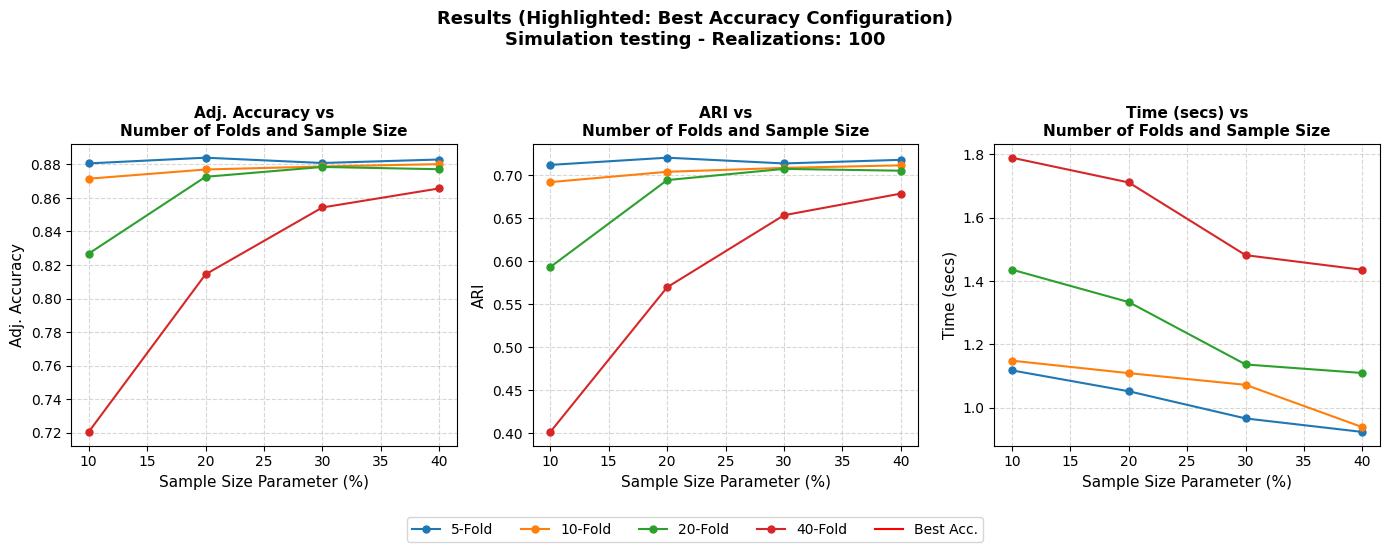

In [6]:
plot_filename = f'plot_results_exp_multifold_{DATA_ID}.png'
save_path = os.path.join(results_dir, plot_filename)

plot_experiment_3_results(
    df=df_avg,                  
    data_name=DATA_ID,          
    num_realizations=100,       
    save_path=save_path
)

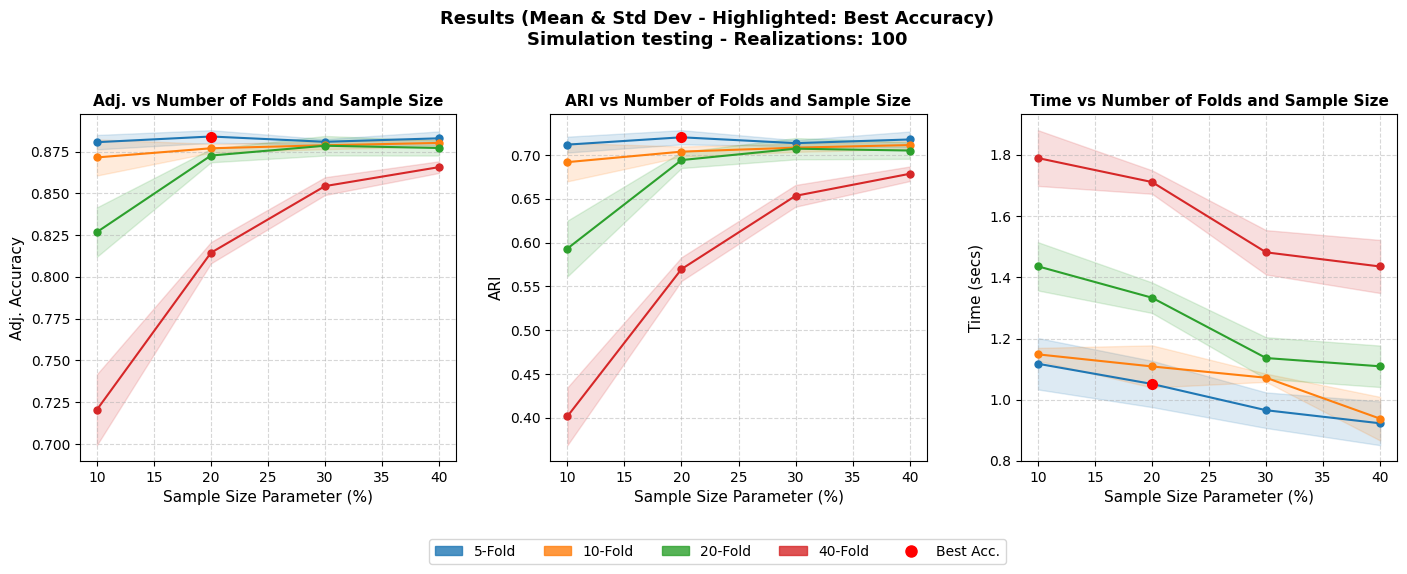

In [24]:
plot_experiment_3_results(
    df=df,                  
    data_name=DATA_ID,          
    num_realizations=100,       
    error_style='fill',
    save_path=save_path

)

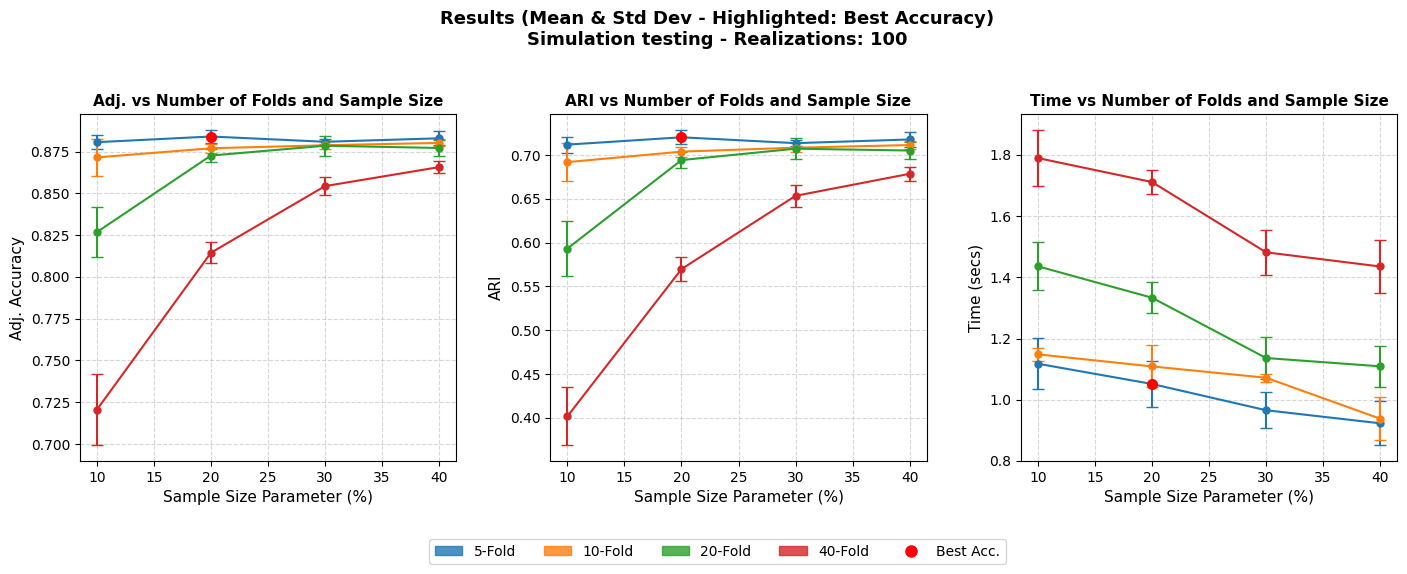

In [25]:
plot_experiment_3_results(
    df=df,                  
    data_name=DATA_ID,          
    num_realizations=100,       
    error_style='bar',
    save_path=save_path

)

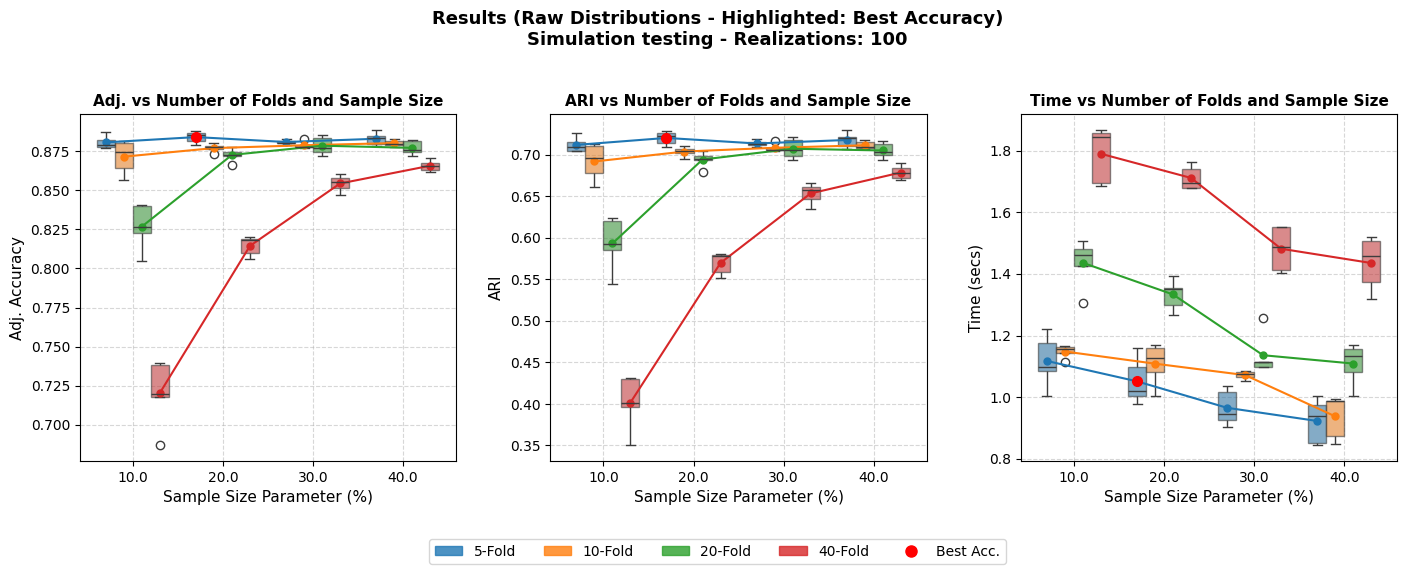

In [26]:
plot_experiment_3_results(
    df=df,                  
    data_name=DATA_ID,          
    num_realizations=100,       
    error_style='boxplot',
    save_path=save_path

)